# Early Plant-Disease Detection
by- **Ayan Naskar** and **Sounak Mukherjee**<br><br>
    This repository contains the code for our project: "Early plant disease detection using Convolutional Neural Network(CNN)
- The model is trained on various images of the leaf of the plant, both healthy and diseased(type of disease).
- This project is aimed to help farmers predict disease in plants at the earliest and take preparations accordingly.


**Before we begin, here are the specifications of the computer where the model was trained are:**
1. CPU - Ryzen 5 4600H
2. GPU - Geforce GTX 1650 Ti (4GB VRAM)
3. RAM - DDR4 16GB dual channel(8+8) @ 3200MHz
4. Storage - 512GB M.2 NVME SSD

## Importing and setting up the variables
importing libraries:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

checking if there is GPU setup in the computer.
- a CNN model trained using GPU is significantly faster than using CPU
- GPU is nearly 3,000% faster in my case
- since my number of gpus available is 1, I can train on GPU.

In [2]:
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices() 

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6666571204328804205
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2694316032
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11191579397070308428
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

setting up the necessary variables

In [3]:
IMAGE_SIZE = 256 # image resolution
BATCH_SIZE = 32 # since tensorflow work in batches
CHANNELS = 3 # since it is rgb image
EPOCHS = 20

## Creating and preparing the dataset

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) # number of batches

68

checking the values in the dataset

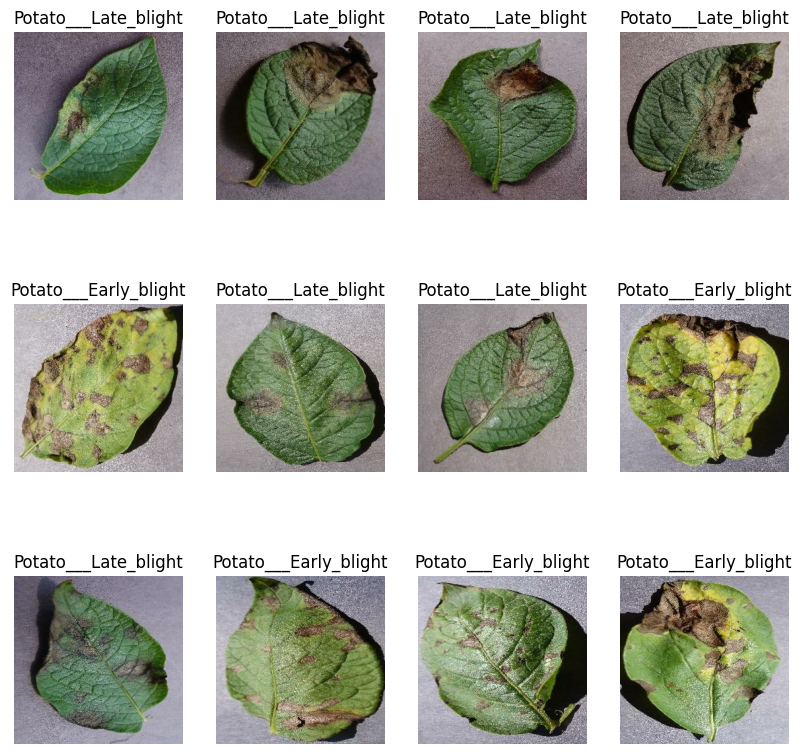

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

- 80% ==> training
- 20% ==> 10% validation, 10% test

Splitting the dataset into **train**, **validation** and **test** data

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    # test_size = int(test_split * ds_size)

    train_ds=ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
# dataset.take(int(len(dataset)*0.5))
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


## Preprocessing and Augumenting the Data

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# this block of code optimises the program by caching.

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
# preprocessing every time so that slight variations while computing wont occur

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# to make our model robust and immune to small variations on real life samples

## Building the **CNN Model**

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)
# 32 layers is just found out by trial and error
# 6 layers is found by trial and error

# relu is a popular activation layer, because is very fast to compute


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 12s 94ms/step - loss: 0.9146 - accuracy: 0.5017 - val_loss: 0.7723 - val_accuracy: 0.5781
Epoch 2/20
54/54 [==============================] - 4s 83ms/step - loss: 0.7089 - accuracy: 0.6759 - val_loss: 0.7643 - val_accuracy: 0.7604
Epoch 3/20
54/54 [==============================] - 4s 83ms/step - loss: 0.4920 - accuracy: 0.7905 - val_loss: 0.3385 - val_accuracy: 0.8802
Epoch 4/20
54/54 [==============================] - 4s 83ms/step - loss: 0.3098 - accuracy: 0.8704 - val_loss: 0.2746 - val_accuracy: 0.8802
Epoch 5/20
54/54 [==============================] - 4s 82ms/step - loss: 0.3016 - accuracy: 0.8819 - val_loss: 0.2995 - val_accuracy: 0.8958
Epoch 6/20
54/54 [==============================] - 4s 83ms/step - loss: 0.3283 - accuracy: 0.8681 - val_loss: 0.1860 - val_accuracy: 0.9219
Epoch 7/20
54/54 [==============================] - 4s 83ms/step - loss: 0.2168 - accuracy: 0.9167 - val_loss: 0.1859 - val_accuracy: 0.9115
Epoch 8/20
5

## Evaluating the Accuracy of our Model

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 26ms/step - loss: 0.1018 - accuracy: 0.9570


In [19]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
history.history['accuracy']

[0.5017361044883728,
 0.6759259104728699,
 0.7905092835426331,
 0.8703703880310059,
 0.8819444179534912,
 0.8680555820465088,
 0.9166666865348816,
 0.9137731194496155,
 0.9351851940155029,
 0.9311342835426331,
 0.9386574029922485,
 0.9403935074806213,
 0.9421296119689941,
 0.9444444179534912,
 0.9565972089767456,
 0.9502314925193787,
 0.953125,
 0.9594907164573669,
 0.9618055820465088,
 0.9629629850387573]

Plotting the graph to better understand the performance of our model

Text(0.5, 1.0, 'Training and Validation Accuracy')

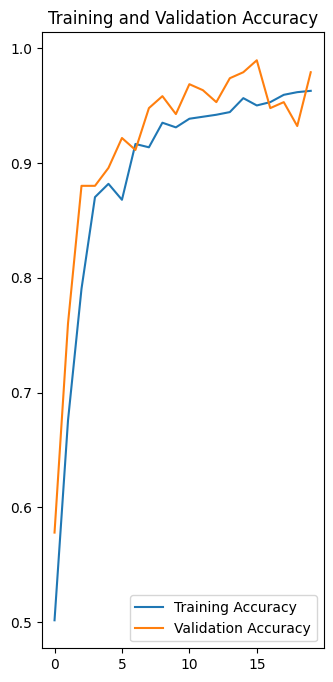

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array, verbose=0)

    predicted_class_number = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_number]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence, predicted_class_number

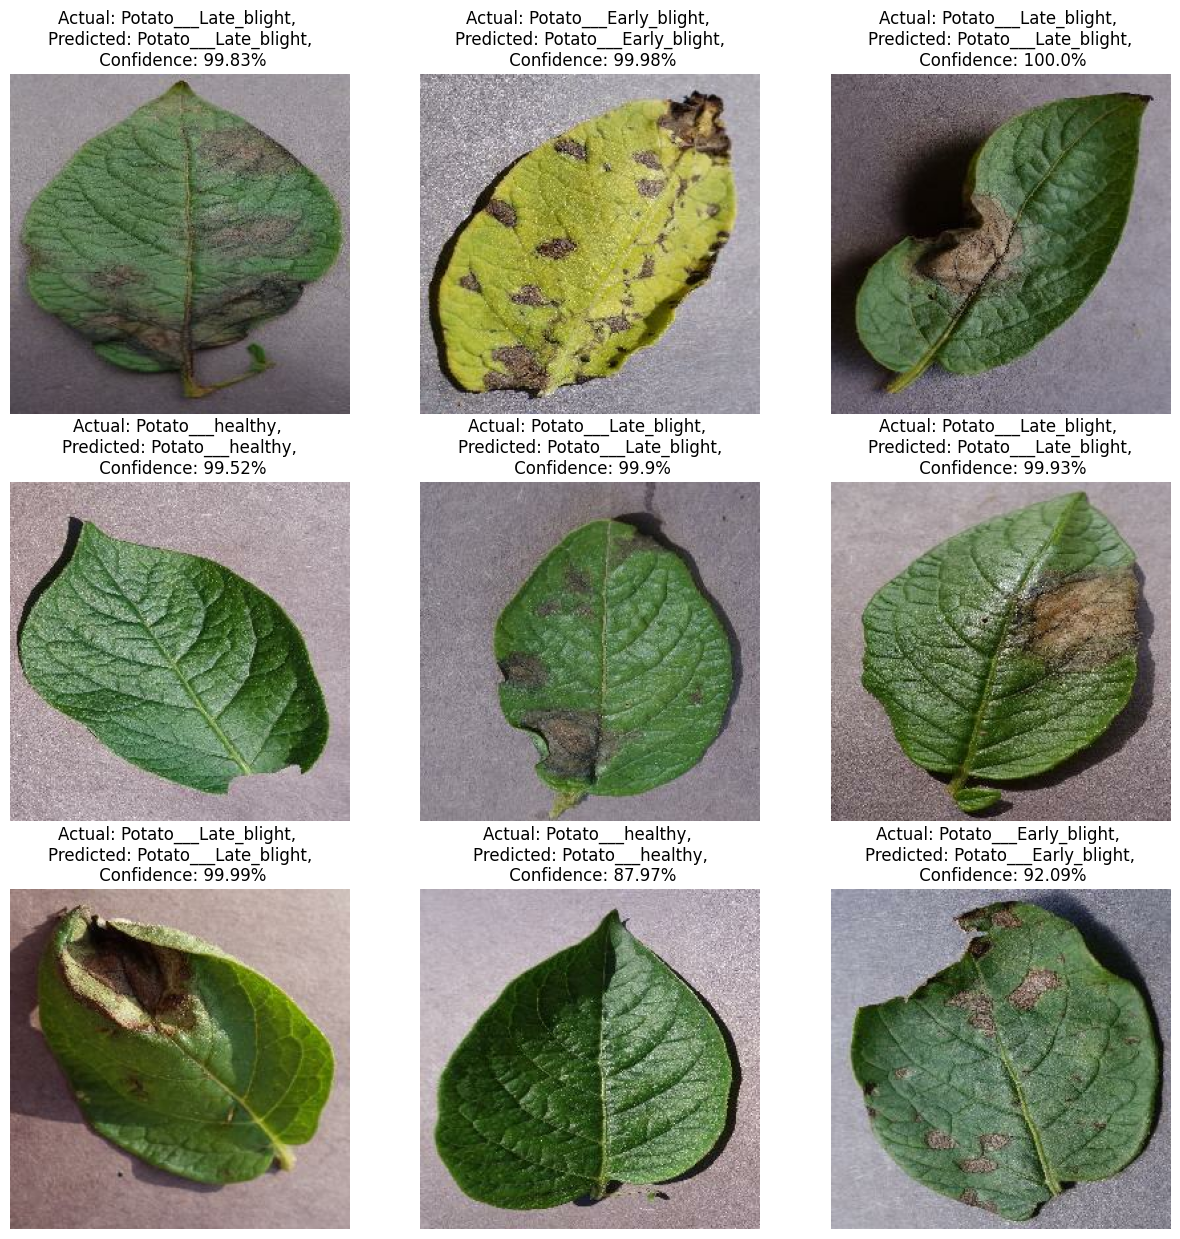

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence, predicted_class_number = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

Printing the **Confusion Matrix** of the Test Data

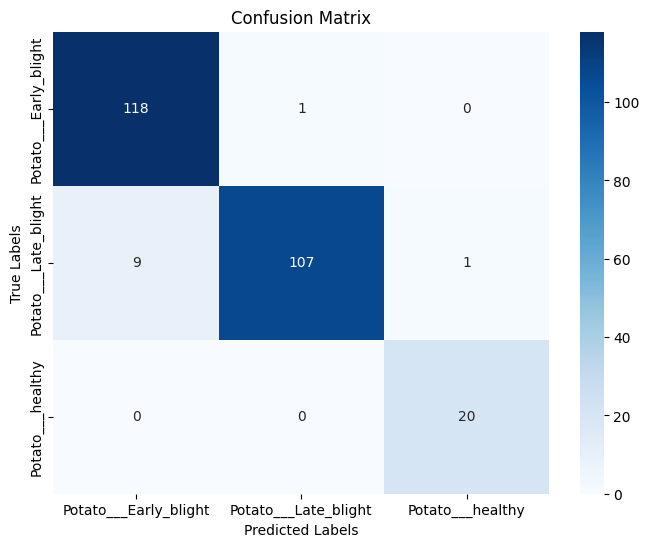

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels=[]
predicted_labels=[]
i=0
for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, _, predicted_class_number = predict(model, images[i].numpy())
        true_labels.append(labels[i].numpy())
        predicted_labels.append(predicted_class_number)

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Since the confusion matrix is diagonal dominant(**Has High Diagonal Values**) we can say, this model is pretty accurate

## Saving our Model

In [26]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/10/assets


INFO:tensorflow:Assets written to: ../saved_models/10/assets
